<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task9(Lite)_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Импорт библиотек и загрузка базы данных**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import time, random
from google.colab import files
from google.colab import drive
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv2DTranspose, Activation, MaxPooling2D, Conv2D #Базовые слои
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import StandardScaler

drive.mount('/content/drive')
#!rm -R '/content/audios_genres' #remove texts directory
#!unzip -q '/content/drive/MyDrive/Colab Notebooks/genres.zip' -d '/content/audios_genres' #unzip to created `texts` directory

Mounted at /content/drive


**2. Создание функций базового автокодировщика, вывода изображений и расчета MSE**



In [ ]:
def baseAutoencoder(shape=(28,28,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 7*7 на 14*14)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 14*14 на 28*28)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
def plotImages(xTrain, pred, shape=(28, 28)): # создадим функцию для вывода изображений как картинок
  n = 10  # количество картинок, которые хотим показать
  plt.figure(figsize=(25, 5)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 28*28      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 28*28     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [ ]:
# Функция для расчета mse
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 0, 0]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.5


## Обучите автокодировщик на 10 выбранных вами красивых цифрах 5 и отредактируйте с помощью него все остальные цифры 5

In [ ]:
(x_train, y_train),(x_test, y_test) = mnist.load_data() # загружаем данные из базы с разбивкой на train/test

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# выделяем из тренировочной и тестовой выборок только пятерки
x_train5=[]
for i in range(len(y_train)):
  if y_train[i]==5:
    x_train5.append(x_train[i])

x_test5=[]
for i in range(len(y_test)):
  if y_test[i]==5:
    x_test5.append(x_test[i])

print(len(x_train5))
print(len(x_test5))

5421
892


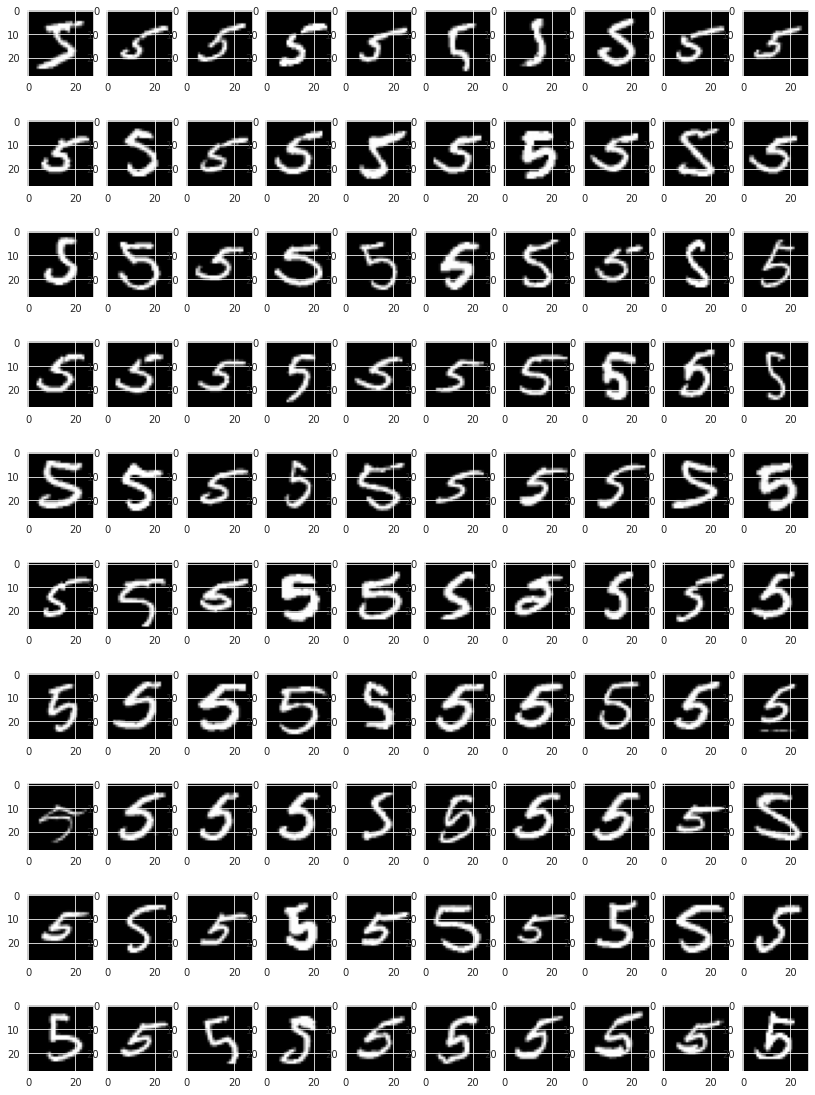

In [ ]:
# отображаем первые 100 пятерок, чтобы выбрать из них 10 красивых
plt.figure(figsize=(14, 20))
for i in range(100):
  ax = plt.subplot(10, 10, i + 1)
  plt.imshow(x_train5[i])
  plt.gray()

In [ ]:
# сохраняем 10 выбранных красивых
x_train5_10=x_train5[16],x_train5[24],x_train5[37],x_train5[49],x_train5[63],x_train5[65],x_train5[66],x_train5[67],x_train5[77],x_train5[87]

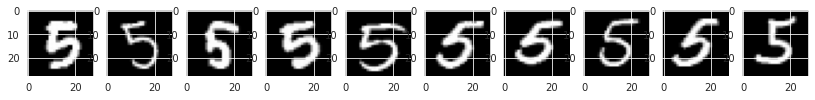

In [ ]:
# отображаем 10 выбранных красивых
plt.figure(figsize=(14, 7))
for i in range(10):
  ax = plt.subplot(1, 10, i + 1)
  plt.imshow(x_train5_10[i])

In [ ]:
# удаляем 10 выбранных красивых из тестовой выборки и формируем одну финишную тестовую выборку из всех оставшихся пятерок
del x_train5[16],x_train5[24],x_train5[37],x_train5[49],x_train5[63],x_train5[65],x_train5[66],x_train5[67],x_train5[77],x_train5[87]
x_test=x_train5+x_test5
len(x_test)

6303

In [ ]:
x_train5_10=np.array(x_train5_10)
x_train5_10 = x_train5_10.astype('float32')/255 # представляем в виде значений от 0 до 1
x_train5_10 = x_train5_10.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам
x_test=np.array(x_test)
x_test = x_test.astype('float32')/255 # представляем в виде значений от 0 до 1
x_test = x_test.reshape(-1, 28, 28, 1) # меняем форму, приводим к нужным нам размерам
print(x_train5_10.shape)
print(x_test.shape)

(10, 28, 28, 1)
(6303, 28, 28, 1)


In [ ]:
modelMnist5 = baseAutoencoder((28,28,1)) # создаем автокодировщик
modelMnist5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Обучаем модель автокодировщика на 10 выбранных красивых пятерках
#history = modelMnist5.fit(x_train5_10, x_train5_10, epochs=200, batch_size=2, validation_data = (x_test, x_test))

Epoch 1/200
5/5 [==============================] - 39s 2s/step - loss: 0.2629 - val_loss: 0.2244
Epoch 2/200
5/5 [==============================] - 7s 2s/step - loss: 0.2231 - val_loss: 0.2169
Epoch 3/200
5/5 [==============================] - 7s 2s/step - loss: 0.2011 - val_loss: 0.2080
Epoch 4/200
5/5 [==============================] - 7s 2s/step - loss: 0.1774 - val_loss: 0.1985
Epoch 5/200
5/5 [==============================] - 7s 2s/step - loss: 0.1616 - val_loss: 0.1891
Epoch 6/200
5/5 [==============================] - 7s 2s/step - loss: 0.1483 - val_loss: 0.1803
Epoch 7/200
5/5 [==============================] - 10s 3s/step - loss: 0.1378 - val_loss: 0.1724
Epoch 8/200
5/5 [==============================] - 7s 2s/step - loss: 0.1290 - val_loss: 0.1652
Epoch 9/200
5/5 [==============================] - 7s 2s/step - loss: 0.1166 - val_loss: 0.1587
Epoch 10/200
5/5 [==============================] - 7s 2s/step - loss: 0.1076 - val_loss: 0.1523
Epoch 11/200
5/5 [===================

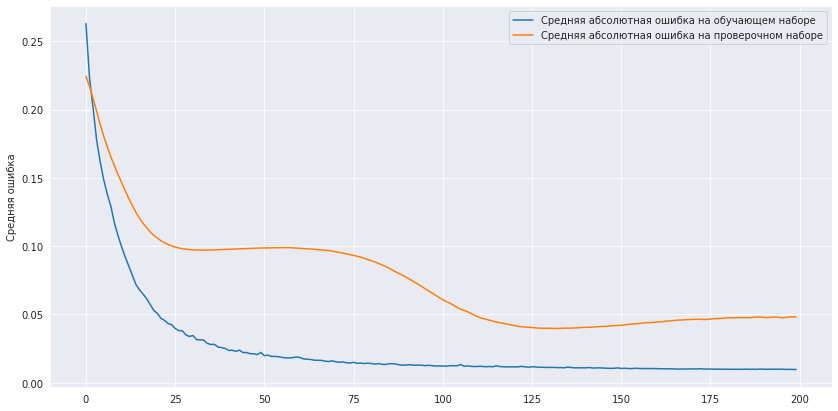

In [ ]:
#Выводим графики
#plt.figure(figsize=(14,7))
#plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
#plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
#plt.ylabel('Средняя ошибка')
#plt.legend()
#plt.show()

In [ ]:
#modelMnist5.save_weights('/content/drive/MyDrive/modelMnist5.h5') # Сохраняем модель

In [ ]:
modelMnist5.load_weights('/content/drive/MyDrive/modelMnist5.h5') # Загружаем модель

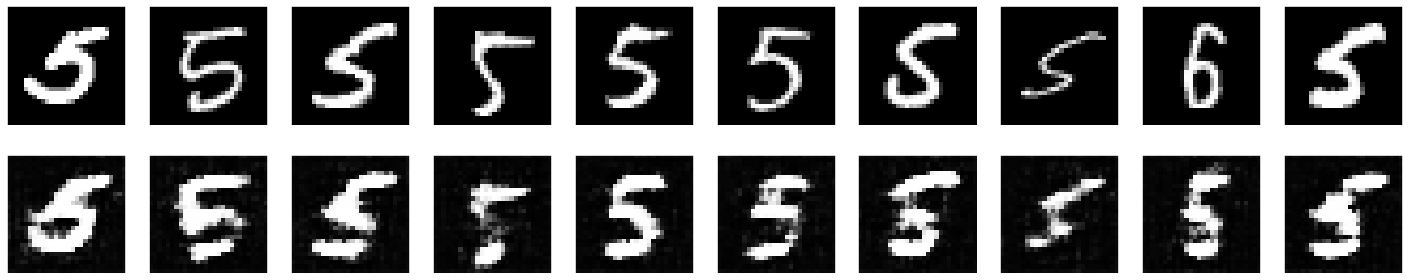

In [ ]:
predMnist5Test = modelMnist5.predict(x_test) # Получаем результат работы модели на тестовой выборке
predMnist5Test = predMnist5Test * 255 # представляем в виде значений от 0 до 255
predMnist5Test = predMnist5Test.astype('uint8') # устанавливаем 8битовый тип
plotImages(x_test, predMnist5Test, shape=(28,28)) # покажем исходные и восстановленные картинки

In [ ]:
predMnist5Train = modelMnist5.predict(x_train5_10) # Получаем результат работы модели на обучающей выборке
predMnist5Train = predMnist5Train * 255 # представляем в виде значений от 0 до 255
predMnist5Train = predMnist5Train.astype('uint8') # устанавливаем 8битовый тип

err1 = [getMSE(x_train5_10[i], predMnist5Train[i] / 255) for i in range(len(predMnist5Train))]# Возьмем среднеквадратичную ошибку от правильной картинки и восстановленной (обучающая выборка)
err2 = [getMSE(x_test[i], predMnist5Test[i] / 255) for i in range(len(predMnist5Test))]# Возьмем среднеквадратичную ошибку от правильной картинки и восстановленной (тестовая выборка)
print("Средняя ошибка на обучающем наборе MNIST:", sum(err1) / x_train5_10.shape[0]) # Отобразим ошибку на обучающей выборке
print("Средняя ошибка на тестовом наборе MNIST:", sum(err2) /x_test.shape[0] ) # Отобразим ошибку на тестовой выборке

Средняя ошибка на обучающем наборе MNIST: 0.009770154810613706
Средняя ошибка на тестовом наборе MNIST: 0.04792066836180259


Получается тестовая выборка как выбросы для обученной модели на идеальных пятерках, потому среднаяя ошибка на обучающей выборке на много меньше, чем на тестовой, где много корявых пятерок.

### Напишите 3 автокодировщика для подавления шума с собственными архитектурами. Сравните их между собой и с исходным шумоподавляющим атокодировщиком. Сравнивайте по квадрату разности исходной картинки с востановленной из шума

**1. Функция исходного шумоподавляющего автокодировщика**

In [ ]:
def denoiseAutoencoder(): # объявляем функцию создания автокодировщика для подавления шума
    img_input = Input((28,28,1)) # задаём входные размеры

    # Добавляем четыре сверточных слоя, вместо MaxPooling используем strides
    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x) # сплющиваем в одномерный вектор - размер 7*5*256
    z = Dense(256, activation='relu')(x) # добавляем полносвязный слой
    x = Dense(7*7*256, activation='relu')(z) 
    x = Reshape((7,7,256))(x) # меняем размеры - картинка 7*7 , 256 ядер
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 7*7 до 14*14
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) # разжимаем картинки из 14*14 до 28*28
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # и пропускаем через финальный слой двумерной свертки

    model = Model(img_input, x) # собрали модель с зашумленной картинкой на вход и с очищенной от шума на выход
    model.compile(optimizer='adam',
                  loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки

    return model # функция вернет модель подавления шума

**2. Функции 3 шумоподавляющих автокодировщиков**

In [ ]:
def denoiseAutoencoder1(shape=(28,28,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    z = BatchNormalization()(x) # и еще слой нормализации данных
    
    
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 7*7 на 14*14)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 14*14 на 28*28)
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
def denoiseAutoencoder2(shape=(28,28,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='sigmoid')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')(x) # далее снова слой двумерной свёртки
    z = BatchNormalization()(x) # и еще слой нормализации данных
    
    
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='sigmoid')(z) # слой разжимает данные(с 7*7 на 14*14)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='sigmoid')(x) # слой разжимает данные(с 14*14 на 28*28)
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
def denoiseAutoencoder3(shape=(28,28,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 7*7 на 14*14)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 14*14 на 28*28)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
# Загрузим данные из Mnist
(x_trainM, y_trainM), (x_testM, y_testM) = mnist.load_data()
x_trainM = x_trainM.astype('float32')/255 # представляем в виде значений от 0 до 1
x_testM = x_testM.astype('float32')/255 # представляем в виде значений от 0 до 1
x_trainM = x_trainM.reshape(x_trainM.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размерам
x_testM = x_testM.reshape(x_testM.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размерам
print(x_trainM.shape)
print(x_testM.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
def addNoise(x, noiseVal): # объявим функцию добавления шума
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape) # создаем шум(с центром в 0.5 и отклонением 0.5)
  # Cкладываем с произведением шума*на усилитель шума и вводим ограничение значений от 0 до 1(clip)
  return np.clip(x + noiseVal * noise, 0., 1.) 

In [ ]:
noisedx_trainM = addNoise(x_trainM, 0.5) # cоздаем зашумленный вариант для x_trainM
noisedx_testM = addNoise(x_testM, 0.5) # cоздаем зашумленный вариант для x_testM

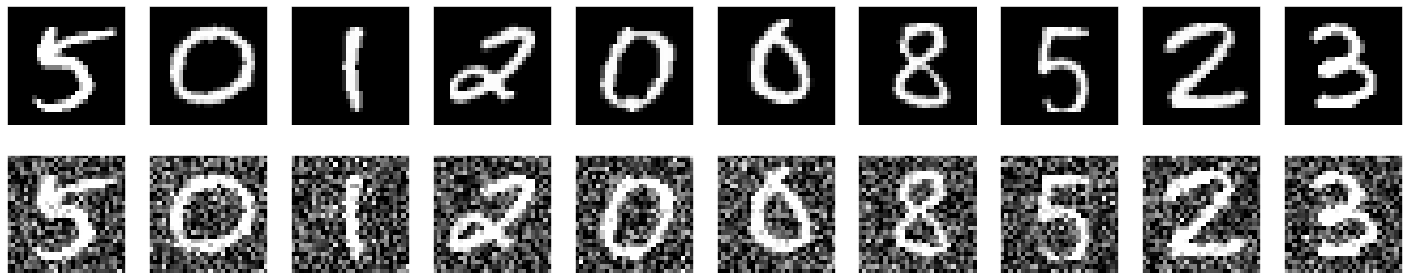

In [ ]:
plotImages(x_trainM, noisedx_trainM) # выведем на экран исходные лица и зашумленные варианты 

**3. Исходный шумоподавляющий автокодировщик**

In [ ]:
modelDenoiseBase = denoiseAutoencoder() # создаем автокодировщик

In [ ]:
# Подаем на вход зашумленные картинки, а на выход правильные, исходные картинки, и обучаем
#modelDenoiseBase.fit(noisedx_trainM, x_trainM, epochs=30, batch_size=100, validation_data = (noisedx_testM, x_testM))

Epoch 1/30
600/600 [==============================] - 21s 34ms/step - loss: 0.0216 - val_loss: 0.0072
Epoch 2/30
600/600 [==============================] - 20s 34ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 3/30
600/600 [==============================] - 20s 33ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 4/30
600/600 [==============================] - 21s 35ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 5/30
600/600 [==============================] - 21s 35ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 6/30
600/600 [==============================] - 20s 33ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 7/30
600/600 [==============================] - 21s 35ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 8/30
600/600 [==============================] - 20s 33ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 9/30
600/600 [==============================] - 20s 33ms/step - loss: 0.0043 - val_loss: 0.0047
Epoch 10/30
600/600 [==============================] - 20s 33ms/step - loss: 0.004

In [ ]:
#modelDenoiseBase.save_weights('/content/drive/MyDrive/modelDenoiseBase.h5') # Сохраняем модель
modelDenoiseBase.load_weights('/content/drive/MyDrive/modelDenoiseBase.h5') # Сохраняем модель

In [ ]:
predDenoiseBase = modelDenoiseBase.predict(noisedx_testM) # подаем зашумленныe тестовые картинки и делаем предикт
predDenoiseBase = predDenoiseBase * 255 # представляем в виде значений от 0 до 255
predDenoiseBase = predDenoiseBase.astype('uint8') # устанавливаем 8битовый тип

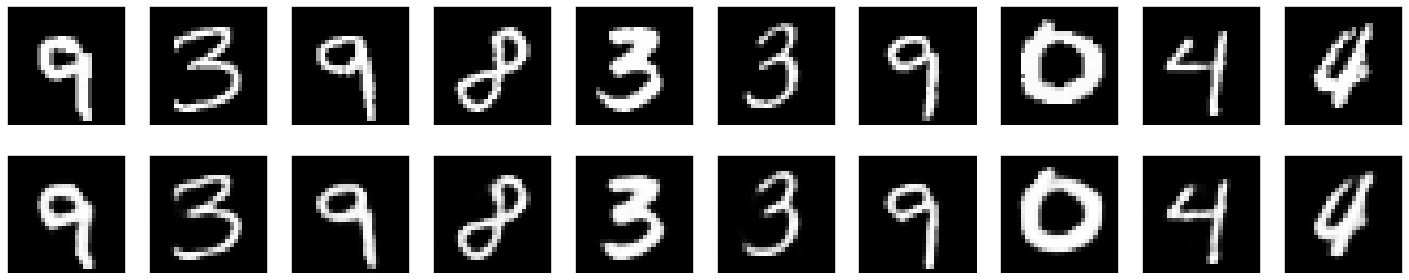

In [ ]:
plotImages(x_testM, predDenoiseBase) # взглянем как отрабатывает шумоподавление на зашумленных картинках

In [ ]:
err_predDenoiseBase = [getMSE(x_testM[i], predDenoiseBase[i] / 255) for i in range(len(predDenoiseBase))]# Возьмем среднеквадратичную ошибку от правильной картинки и шумоподавленной (тестовая выборка)
print("Средняя ошибка на тестовом наборе MNIST для исходной шумоподавляющей модели:", sum(err_predDenoiseBase) /x_testM.shape[0] ) # Отобразим ошибку на тестовой выборке

Средняя ошибка на тестовом наборе MNIST для исходной шумоподавляющей модели: 0.004490232556169909


**4. Первый шумоподавляющий автокодировщик**

In [ ]:
modelDenoise1 = denoiseAutoencoder1() # создаем автокодировщик
# Подаем на вход зашумленные картинки, а на выход правильные, исходные картинки, и обучаем
#modelDenoise1.fit(noisedx_trainM, x_trainM, epochs=30, batch_size=100, validation_data = (noisedx_testM, x_testM))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
600/600 [==============================] - 36s 7ms/step - loss: 0.0513 - val_loss: 0.0146
Epoch 2/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0124 - val_loss: 0.0093
Epoch 3/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0086 - val_loss: 0.0071
Epoch 4/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 5/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 6/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 7/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 8/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 9/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 10/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0045 - val_loss: 0.004

In [ ]:
#modelDenoise1.save_weights('/content/drive/MyDrive/modelDenoise1.h5') # Сохраняем модель
modelDenoise1.load_weights('/content/drive/MyDrive/modelDenoise1.h5') # Сохраняем модель

In [ ]:
predDenoise1 = modelDenoise1.predict(noisedx_testM) # подаем зашумленныe тестовые картинки и делаем предикт
predDenoise1 = predDenoise1 * 255 # представляем в виде значений от 0 до 255
predDenoise1 = predDenoise1.astype('uint8') # устанавливаем 8битовый тип

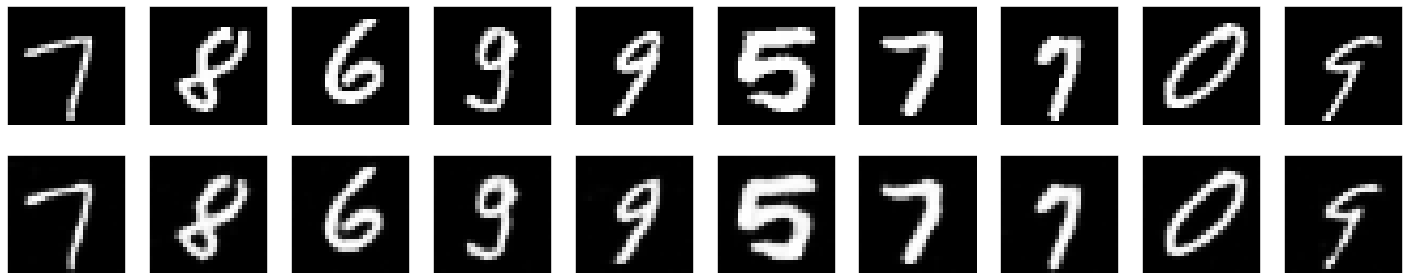

In [ ]:
plotImages(x_testM, predDenoise1) # взглянем как отрабатывает шумоподавление на зашумленных картинках

In [ ]:
err_predDenoise1 = [getMSE(x_testM[i], predDenoise1[i] / 255) for i in range(len(predDenoise1))]# Возьмем среднеквадратичную ошибку от правильной картинки и шумоподавленной (тестовая выборка)
print("Средняя ошибка на тестовом наборе MNIST для 1 шумоподавляющей модели:", sum(err_predDenoise1) /x_testM.shape[0] ) # Отобразим ошибку на тестовой выборке

Средняя ошибка на тестовом наборе MNIST для 1 шумоподавляющей модели: 0.003875696422072821


**5. Второй шумоподавляющий автокодировщик**

In [ ]:
modelDenoise2 = denoiseAutoencoder2() # создаем автокодировщик
# Подаем на вход зашумленные картинки, а на выход правильные, исходные картинки, и обучаем
#modelDenoise2.fit(noisedx_trainM, x_trainM, epochs=30, batch_size=100, validation_data = (noisedx_testM, x_testM))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
600/600 [==============================] - 5s 8ms/step - loss: 0.0694 - val_loss: 0.0234
Epoch 2/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 3/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 4/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 5/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 6/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 7/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 8/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/30
600/600 [==============================] - 4s 7ms/step - loss: 0.0048 - val_loss: 0.0047

In [ ]:
#modelDenoise2.save_weights('/content/drive/MyDrive/modelDenoise2.h5') # Сохраняем модель
modelDenoise2.load_weights('/content/drive/MyDrive/modelDenoise2.h5') # Сохраняем модель

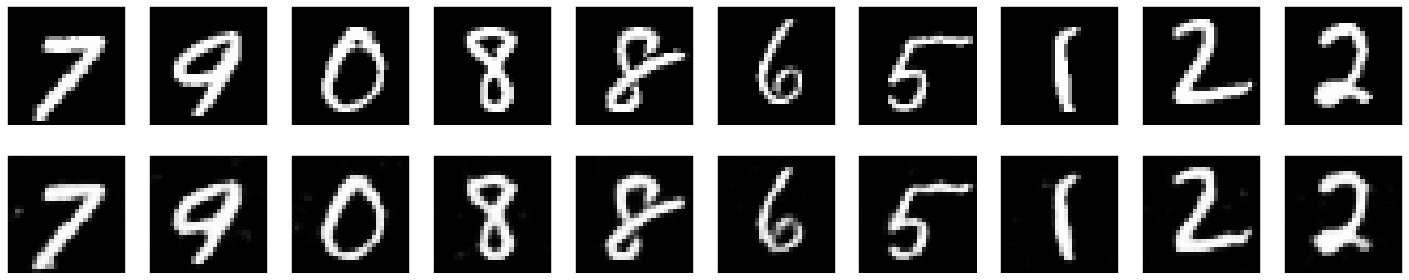

In [ ]:
predDenoise2 = modelDenoise2.predict(noisedx_testM) # подаем зашумленныe тестовые картинки и делаем предикт
predDenoise2 = predDenoise2 * 255 # представляем в виде значений от 0 до 255
predDenoise2 = predDenoise2.astype('uint8') # устанавливаем 8битовый тип
plotImages(x_testM, predDenoise2) # взглянем как отрабатывает шумоподавление на зашумленных картинках

In [ ]:
err_predDenoise2 = [getMSE(x_testM[i], predDenoise2[i] / 255) for i in range(len(predDenoise2))]# Возьмем среднеквадратичную ошибку от правильной картинки и шумоподавленной (тестовая выборка)
print("Средняя ошибка на тестовом наборе MNIST для 1 шумоподавляющей модели:", sum(err_predDenoise2) /x_testM.shape[0] ) # Отобразим ошибку на тестовой выборке

Средняя ошибка на тестовом наборе MNIST для 1 шумоподавляющей модели: 0.004173117535522237


**6. Третий шумоподавляющий автокодировщик**

In [ ]:
modelDenoise3 = denoiseAutoencoder3() # создаем автокодировщик
#modelDenoise3.fit(noisedx_trainM, x_trainM, epochs=30, batch_size=100, validation_data = (noisedx_testM, x_testM))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
600/600 [==============================] - 13s 20ms/step - loss: 0.0448 - val_loss: 0.0120
Epoch 2/30
600/600 [==============================] - 12s 19ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 3/30
600/600 [==============================] - 11s 19ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 4/30
600/600 [==============================] - 12s 19ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 5/30
600/600 [==============================] - 11s 19ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 6/30
600/600 [==============================] - 12s 19ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 7/30
600/600 [==============================] - 12s 19ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 8/30
600/600 [==============================] - 12s 20ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/30
600/600 [==============================] - 12s 19ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/30
600/600 [==============================] - 12s 19ms/step - loss: 0.004

In [ ]:
#modelDenoise3.save_weights('/content/drive/MyDrive/modelDenoise3.h5') # Сохраняем модель
modelDenoise3.load_weights('/content/drive/MyDrive/modelDenoise3.h5') # Сохраняем модель

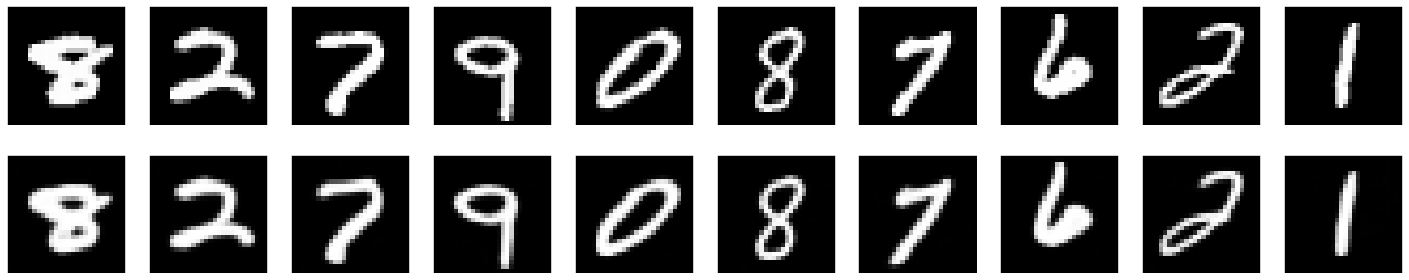

In [ ]:
predDenoise3 = modelDenoise3.predict(noisedx_testM) # подаем зашумленныe тестовые картинки и делаем предикт
predDenoise3 = predDenoise3 * 255 # представляем в виде значений от 0 до 255
predDenoise3 = predDenoise3.astype('uint8') # устанавливаем 8битовый тип
plotImages(x_testM, predDenoise3) # взглянем как отрабатывает шумоподавление на зашумленных картинках

In [ ]:
err_predDenoise3 = [getMSE(x_testM[i], predDenoise3[i] / 255) for i in range(len(predDenoise3))]# Возьмем среднеквадратичную ошибку от правильной картинки и шумоподавленной (тестовая выборка)
print("Средняя ошибка на тестовом наборе MNIST для 1 шумоподавляющей модели:", sum(err_predDenoise3) /len(err_predDenoise3) ) # Отобразим ошибку на тестовой выборке

Средняя ошибка на тестовом наборе MNIST для 1 шумоподавляющей модели: 0.0034804915720450668


Последняя модель со сверточными слоями и наибольшим количеством слоев самая эффективная с наименьшей ошибкой.

##Обучите автокодировщик на базе Fashion Mnist, проверьте, как он преобразует картинки одежды, на которых не обучался.

In [ ]:
# Загрузим данные из fashion_mnist - базы с одеждой,обувью и т.п
(x_trainF, y_trainF), (x_testF, y_testF) = fashion_mnist.load_data()
x_trainF = x_trainF.astype('float32')/255 # представляем в виде значений от 0 до 1
x_testF = x_testF.astype('float32')/255 # представляем в виде значений от 0 до 1
x_trainF = x_trainF.reshape(x_trainF.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размерам
x_testF = x_testF.reshape(x_testF.shape[0], 28, 28, 1) # меняем форму, приводим к нужным нам размерам
print(x_trainF.shape)
print(x_testF.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


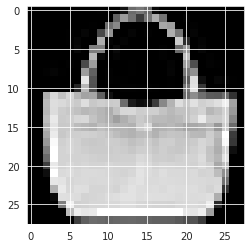

In [ ]:
# Взглянем на пример изображения из базы fashion_mnist
n = 100 # выбираем картинку
plt.imshow(x_trainF[n].reshape((28,28)),cmap='gray') # переводим в 4х-канальное цветовое пространство RGBA
plt.show() # покажем картинку

In [ ]:
modelMnistF = baseAutoencoder((28,28,1)) # создаем автокодировщик
# Обучаем модель автокодировщика на базе Fashion Mnist
history = modelMnistF.fit(x_trainF, x_trainF, epochs=100, batch_size=256, validation_data = (x_testF, x_testF))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
235/235 [==============================] - 12s 45ms/step - loss: 0.0424 - val_loss: 0.1177
Epoch 2/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0156 - val_loss: 0.0208
Epoch 3/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 4/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 5/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 6/100
235/235 [==============================] - 10s 43ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 7/100
235/235 [==============================] - 10s 44ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 8/100
235/235 [==============================] - 10s 44ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 9/100
235/235 [==============================] - 10s 44ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 10/100
235/235 [==============================] - 10s 44ms/step - l

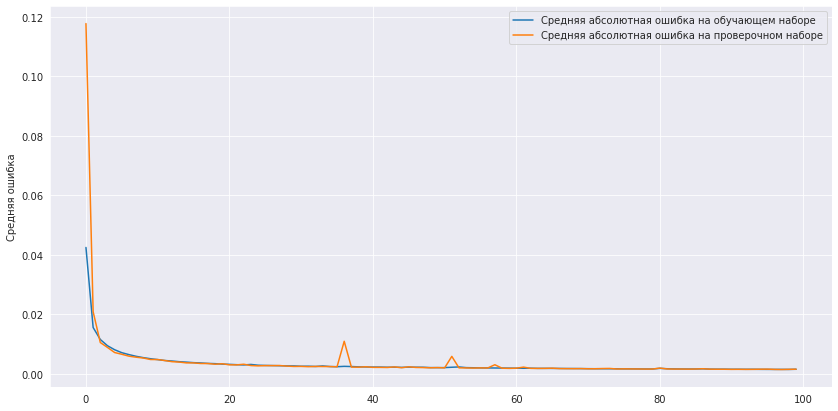

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

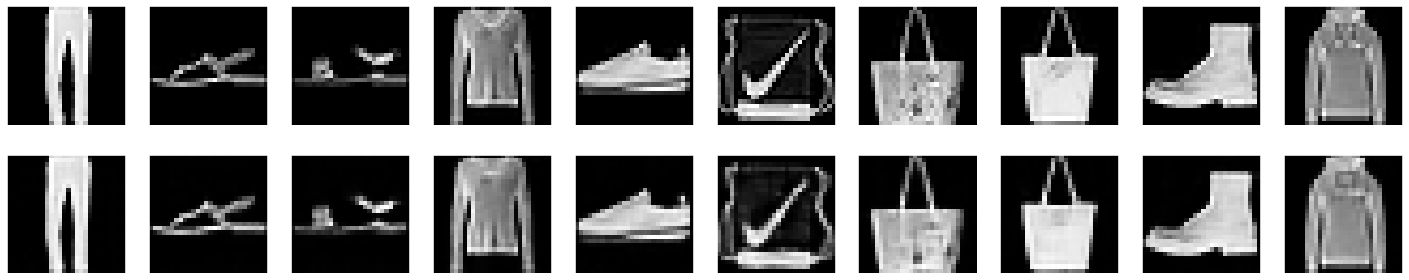

In [ ]:
predMnistF = modelMnistF.predict(x_testF) # сделаем предикт для тестовых картинок из fashion_mnist
predMnistF = predMnistF * 255 # представляем в виде значений от 0 до 255
predMnistF = predMnistF.astype('uint8') # устанавливаем 8битовый тип
plotImages(x_testF, predMnistF, shape=(28,28)) # выведем на экран картинки правильных и восстановленных изображений 

In [ ]:
errF = [getMSE(x_testF[i], predMnistF[i] / 255) for i in range(len(predMnistF))]
print("Средняя ошибка на одежде:", round(sum(errF) / len(errF), 4))

Средняя ошибка на одежде: 0.0016
